In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torch.optim.optimizer import Optimizer
from tqdm import tqdm
%matplotlib inline

In [2]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    torchvision.transforms.RandomRotation(10),
    torchvision.transforms.RandomAffine(0, translate=(0.1, 0.1)),
    torchvision.transforms.Resize((32, 32)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size = 2048

# data_path = '../../../../autoencoder/'
data_path = './'

trainset = torchvision.datasets.CIFAR10(root=data_path, train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=16, pin_memory=True)

testset = torchvision.datasets.CIFAR10(root=data_path, train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=16, pin_memory=True)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [3]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


## Natural gradient descent optimizer

In [5]:
class NaturalGradientDescent(Optimizer):
    """
    Natural gradient descent optimizer.

    Args:
        params (iterable): iterable of parameters to optimize or dicts defining parameter groups
        lr (float, optional): learning rate (default: 1e-3)
        tol (float, optional): tolerance for conjugate gradient solver (default: 1e-5)
        max_iter (int, optional): maximum number of iterations for conjugate gradient solver (default: 100
    """
    def __init__(self, params, lr=1e-3, tol=1e-5, max_iter=1000):
        if not 0.0 < lr:
            raise ValueError(f"Invalid learning rate: {lr}")
        defaults = {"lr": lr, "tol": tol, "max_iter": max_iter}
        super(NaturalGradientDescent, self).__init__(params, defaults)

    def _compute_fisher_vector_product(self, grad):
        """
        Compute Fisher vector product
        
        Args:
            grad (torch.Tensor): gradient tensor
        """
        original_shape = grad.shape
        # Flatten to 2D: (batch_size, -1)
        grad_flat = grad.reshape(original_shape[0], -1)
        # Compute Fisher matrix
        fisher_matrix = grad_flat @ grad_flat.T + 1e-5 * torch.eye(
            grad_flat.size(0), device=grad.device
        )
        return fisher_matrix, original_shape

    def _conjugate_gradient(self, fisher_matrix, grad, tol, max_iter):
        """
        Conjugate gradient method to solve for Fw^-1 @ grad
        
        Args:
            fisher_matrix (torch.Tensor): Fisher matrix
            grad (torch.Tensor): gradient tensor
            tol (float): tolerance for conjugate gradient solver
            max_iter (int): maximum number of iterations for conjugate gradient solver
        """
        original_shape = grad.shape
        grad_flat = grad.reshape(original_shape[0], -1)
        
        # Initialize solution and r vector
        x = torch.zeros_like(grad_flat)
        r = grad_flat.clone()
        p = r.clone()
        rs_old = torch.sum(r * r)

        # Solve for Fw^-1 @ grad using conjugate gradient
        for _ in range(max_iter):
            Ap = fisher_matrix @ p
            alpha = rs_old / (torch.sum(p * Ap) + 1e-8)
            x += alpha * p
            r -= alpha * Ap
            rs_new = torch.sum(r * r)

            # Check for convergence
            if torch.sqrt(rs_new) < tol:
                break

            # Update p vector
            p = r + (rs_new / rs_old) * p
            rs_old = rs_new

        # Reshape solution back to original dimensions
        return x.reshape(original_shape)

    @torch.no_grad()
    def step(self, closure=None):
        loss = closure() if closure else None

        for group in self.param_groups:
            lr = group["lr"]
            tol = group["tol"]
            max_iter = group["max_iter"]

            for param in group["params"]:
                if param.grad is None:
                    continue

                grad = param.grad.data
                fisher_matrix, original_shape = self._compute_fisher_vector_product(grad)
                natural_grad = self._conjugate_gradient(fisher_matrix, grad, tol, max_iter)
                
                # Update parameter using natural gradient
                param.data -= lr * natural_grad

        return loss

# Shampoo optimizer

In [6]:
class Shampoo(Optimizer):
    def __init__(self, params, lr=1e-1, momentum=0, weight_decay=0, epsilon=1e-4, diag_cutoff=1e3, update_freq_sched=lambda x: 1, inv_p_root_device='cpu', svd_rank=None, newton_num_iters=5, newton_num_iters_max_sv=5):
        """
        Shampoo optimizer for training deep neural networks.

        Args:
            params (iterable): iterable of parameters to optimize or dicts defining parameter groups
            lr (float, optional): learning rate (default: 1e-1)
            momentum (float, optional): momentum factor (default: 0)
            weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
            epsilon (float, optional): epsilon value for numerical stability (default: 1e-4)
            diag_cutoff (float, optional): diagonal cutoff value for preconditioner (default: 1e3)
            update_freq_sched (callable, optional): update frequency scheduler for preconditioner (default: lambda x: 1)
            inv_p_root_device (str, optional): device to compute the inverse square root of the preconditioner (default: 'cpu')
            svd_rank (int, optional): rank of the SVD approximation for the inverse square root of the preconditioner (default: None)
            newton_num_iters (int, optional): number of Newton iterations for the inverse square root of the preconditioner (default: 5)
            newton_num_iters_max_sv (int, optional): number of Newton iterations for the largest singular value (default: 5)
        """
        defaults = dict(lr=lr, momentum=momentum, weight_decay=weight_decay, epsilon=epsilon, diag_cutoff=diag_cutoff)
        super(Shampoo, self).__init__(params, defaults)
        self.update_freq_sched = update_freq_sched
        self.inv_p_root_device = inv_p_root_device
        self.svd_rank = svd_rank
        self.newton_num_iters = newton_num_iters
        self.newton_num_iters_max_sv = newton_num_iters_max_sv

    @torch.no_grad()
    def max_sv(self, G, error_tolerance=1e-6, device='cpu'):
        """
        Computes the largest singular value of G using iteratively.
        
        Args:
            G (torch.Tensor): input matrix
            error_tolerance (float, optional): error tolerance for convergence (default: 1e-6)
            device (str, optional): device to compute the largest singular value (default: 'cpu')
        """
        num_iters = self.newton_num_iters_max_sv
        G = G.to(device)
        n = G.size(0)
        v = torch.randn(n, device=device)
        sv = 0

        for _ in range(num_iters):
            v_hat = v / v.norm()
            v = G @ v_hat
            # old_sv = sv
            sv = v_hat @ v
            # if abs(old_sv - sv) < error_tolerance:
            #     break

        return sv
    
    @torch.no_grad()
    def matrix_pow_newton(self, G, power, error_tolerance=1e-5, ridge_epsilon=1e-6, device='cpu'):
        """
        Computes G^(-1/power) using Coupled Newton iterations.
        
        Args:
            G (torch.Tensor): input matrix
            power (float): power of the matrix
            error_tolerance (float, optional): error tolerance for convergence (default: 1e-5)
            ridge_epsilon (float, optional): ridge epsilon for numerical stability (default: 1e-6)
            device (str, optional): device to compute the matrix power (default
        """
        dev = G.device
        G = G.to(device)
        num_iters = self.newton_num_iters

        mat_size = G.size(0)
        identity = torch.eye(mat_size, device=device)
        max_eigenvalue = self.max_sv(G, error_tolerance=error_tolerance, device=device)
        ridge_epsilon = ridge_epsilon * max(max_eigenvalue, 1e-16)
        damped_mat_g = G + ridge_epsilon * identity

        alpha = -1.0 / power
        z = (1 + power) / (2 * torch.linalg.norm(damped_mat_g))
        mat_m = damped_mat_g * z
        mat_h = identity * z**(1 / power)
        # error = torch.max(torch.abs(mat_m - identity))

        for _ in range(num_iters):
            # if error < error_tolerance:
            #     break
            mat_m_i = (1 - alpha) * identity + alpha * mat_m
            mat_h = mat_h @ mat_m_i
            mat_m = mat_m_i.matrix_power(power) @ mat_m
            # error = torch.max(torch.abs(mat_m - identity))

        return mat_h.to(dev)
    
    @torch.no_grad()
    def matrix_pow_svd(self, matrix, power, rank=None, device='cpu'):
        """
        Computes the matrix power using the SVD decomposition.
        
        Args:
            matrix (torch.Tensor): input matrix
            power (float): power of the matrix
            rank (int, optional): rank of the SVD approximation (default: None)
            device (str, optional): device to compute the matrix power (default
        """
        if matrix.device == device:
            matrix_dev = matrix
        else:
            matrix_dev = matrix.to(device)
        
        rank = min(rank, min(matrix_dev.size())) if rank is not None else min(matrix_dev.size())
        u, sigma, v = torch.svd_lowrank(matrix_dev, q=rank)  # Use low-rank SVD for speed
        return (u @ sigma.pow(power).diag() @ v.t()).to(matrix.device)

    @torch.no_grad()
    def block_diagonal_approx(self, matrix, block_size=32):
        """
        Computes the block-diagonal approximation of the matrix.
        
        Args:
            matrix (torch.Tensor): input matrix
            block_size (int, optional): block size for the approximation (default: 32)
        """
        n = matrix.size(0)
        if n <= block_size:
            return matrix
        num_blocks = (n + block_size - 1) // block_size
        padded_size = num_blocks * block_size
        padding = padded_size - n
        matrix_padded = F.pad(matrix, (0, padding, 0, padding))
        matrix_padded = matrix_padded.view(num_blocks, block_size, num_blocks, block_size)
        eye = torch.eye(num_blocks, device=matrix.device).view(num_blocks, 1, num_blocks, 1)
        matrix_padded = matrix_padded * eye
        matrix_padded = matrix_padded.view(padded_size, padded_size)
        return matrix_padded[:n, :n]
            
    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue

                # Receive loss function f_t: R^(n1x...xnk) -> R
                grad = p.grad.data          # Gt
                n_dim = grad.ndimension()   # k
                grad_size = grad.size()     # (n1, ..., nk)
                momentum = group['momentum']
                weight_decay = group['weight_decay']

                # Initialize the preconditioner matrix
                state = self.state[p]
                if len(state) == 0:
                    state['step'] = 0
                    if momentum > 0:
                        state['momentum_buffer'] = grad.clone()

                    # Create preconditioner matrices for each dimension of the gradient
                    for i, dim in enumerate(grad.size()):
                        if (dim > group['diag_cutoff']):
                            # Initialize the preconditioner H_0^i = epsilon * I_ni
                            state[f'precond_{i}'] = group['epsilon'] * torch.ones(dim, device=grad.device)
                            state[f'inv_precond_{i}'] = torch.zeros(dim, device=grad.device)
                        else:
                            # Initialize the preconditioner H_0^i = epsilon * I_ni
                            state[f'precond_{i}'] = group['epsilon'] * torch.eye(dim, device=grad.device)
                            state[f'inv_precond_{i}'] = torch.zeros(dim, dim, device=grad.device)

                update_freq = self.update_freq_sched(state['step'])

                if momentum > 0:
                    # Apply momentum to the gradient
                    grad = grad * (1 - momentum) + state["momentum_buffer"] * momentum

                if weight_decay > 0:
                    # Add weight decay to the gradient [L2 regularization: L<-L+λw**2 => grad<-grad+2λw]
                    # grad = grad + p.data * weight_decay
                    grad.add_(p.data, alpha=weight_decay)

                # Update the weights for each dimension of the gradient
                for i, dim in enumerate(grad.size()):
                    precond = state[f'precond_{i}']

                    ## Block-diagonal approximation
                    # if (dim > group['diag_cutoff']):
                    #     precond = self.block_diagonal_approx(precond, block_size=4)

                    inv_precond_pow = state[f'inv_precond_{i}']

                    grad = grad.transpose(0, i).contiguous()
                    grad_size_t = grad.size()
                    grad = grad.view(dim, -1)

                    if (dim > group['diag_cutoff']):
                        # Use diagonal variant of shampoo
                        # precond += torch.diagonal(grad @ grad.t())
                        precond.add_(torch.diagonal(grad @ grad.t()))
                        if state['step'] % update_freq == 0:
                            inv_precond_pow = precond.pow(-1 / (2*n_dim)).clone()
                    else:
                        # Update preconditioner matrix
                        # precond += grad @ grad.t()
                        precond.addmm_(grad, grad.t())
                        if state['step'] % update_freq == 0:
                            # inv_precond_pow = self.matrix_pow_svd(precond, -1 / (2*n_dim), rank=self.svd_rank, device=self.inv_p_root_device).clone()
                            inv_precond_pow = self.matrix_pow_newton(precond, 2*n_dim, device=self.inv_p_root_device).clone()

                    # Compute the preconditioned gradient
                    if i == n_dim - 1:
                        if (dim > group['diag_cutoff']):
                            grad = grad.t() @ inv_precond_pow.diag()
                        else:
                            grad = grad.t() @ inv_precond_pow
                        grad = grad.view(grad_size)
                    else:
                        if (dim > group['diag_cutoff']):
                            grad = inv_precond_pow.diag() @ grad
                        else:
                            grad = inv_precond_pow @ grad
                        grad = grad.view(grad_size_t)

                # Update the state
                state['step'] += 1
                state['momentum_buffer'] = grad

                # Update the weights                
                p.data = p.data - grad * group['lr']

        return loss

# Defining Convolutional neural network for classification

In [7]:
class convBlock(nn.Module):
    """A convolutional block with batch normalization and activation function.
    
    Args:
        in_channels (int): Number of input channels
        out_channels (int): Number of output channels
        kernel_size (int): Size of the convolving kernel
        stride (int): Stride of the convolution
        padding (int): Padding added to all sides of the input
        batch_norm (bool, optional): Whether to use batch normalization. Defaults to True
        act (nn.Module, optional): Activation function to use. Defaults to LeakyReLU
    """
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, batch_norm=True, act=None):
        super().__init__()
        # Convolutional layer with optional bias (disabled when using batch norm)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=(not batch_norm))
        # Default activation is LeakyReLU with negative slope 0.2
        self.act = nn.LeakyReLU(0.2, inplace=True) if act == None else act
        # Batch normalization layer or identity if batch_norm=False
        self.bn = nn.BatchNorm2d(out_channels) if batch_norm else nn.Identity()

    def forward(self, x):
        """Forward pass: conv -> batch norm -> activation"""
        return self.act(self.bn(self.conv(x)))

class CNN(nn.Module):
    """A CNN architecture for image classification.
    
    Architecture:
    - 8 convolutional blocks with increasing number of channels (3->64->64->128->128->256->256->512->512)
    - Each block includes convolution, batch normalization, and LeakyReLU
    - Downsampling is achieved through strided convolutions
    - Final classifier layer maps to 10 classes (CIFAR-10)
    """
    def __init__(self):
        super().__init__()
        # Sequential model of convolutional blocks
        self.model = nn.Sequential(
            convBlock(3, 64, 4, 2, 1),
            convBlock(64, 64, 3, 1, 1),
            convBlock(64, 128, 4, 2, 1),
            convBlock(128, 128, 3, 1, 1),
            convBlock(128, 256, 4, 2, 1),
            convBlock(256, 256, 3, 1, 1),
            convBlock(256, 512, 4, 2, 1),
            convBlock(512, 512, 4, 2, 1)
        )
        # Final classification layer
        self.aux_classifier = nn.Linear(512, 10)
    
    def forward(self, x):
        """Forward pass through the network.
        
        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, 3, H, W)
            
        Returns:
            torch.Tensor: Logits for 10 classes
        """
        x = self.model(x)  # Pass through CNN layers
        x = x.view(x.size(0), -1)  # Flatten the output for the classifier
        x = self.aux_classifier(x)  # Classify into 10 classes
        return x

In [8]:
import copy

# Initialize the network
torch.manual_seed(0)
net = CNN().to(device)

# Save the initial state for comparison later on
initial_state = copy.deepcopy(net.state_dict())

# Initialize lists to store losses and steps
losses = []
steps = []

In [9]:
torch.manual_seed(0)

criterion = nn.CrossEntropyLoss()

# Initialize the optimizers
def update_freq_sched(step):
    return 1
optimizer1 = Shampoo(net.parameters(),
    lr=1e-1,
    epsilon=1e-4,
    weight_decay=0,
    diag_cutoff=1e3,
    update_freq_sched=update_freq_sched,
    inv_p_root_device=device,                 # Coupled Newton's iterations are faster on gpu
    # inv_p_root_device='cpu',                # SVD is faster on cpu
    svd_rank=100,
    newton_num_iters=5,
    newton_num_iters_max_sv=5,
)
optimizer2 = optim.Adam(net.parameters(), lr=2e-4)
optimizer3 = NaturalGradientDescent(net.parameters(), lr=9e-4, tol=1e-5, max_iter=10)

Shampoo - Epoch 20: 100%|██████████| 25/25 [00:03<00:00,  6.72it/s, loss=0.701]


Accuracy of the network on the test set: 69.07%


Adam - Epoch 20: 100%|██████████| 25/25 [00:02<00:00,  8.55it/s, loss=0.64] 


Accuracy of the network on the test set: 73.45%


NaturalGradientDescent - Epoch 20: 100%|██████████| 25/25 [00:04<00:00,  5.93it/s, loss=0.309]


Accuracy of the network on the test set: 82.29%


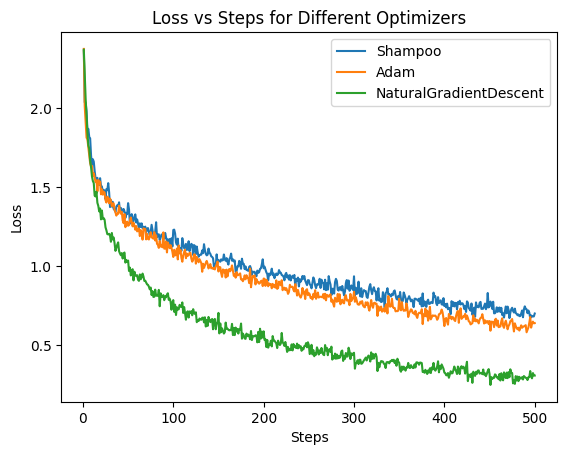

In [10]:
# Initialize a dictionary for tracking losses for each optimizer
optimizer_losses = {}

# List of optimizers to test
optimizers = [
    optimizer1,
    optimizer2,
    optimizer3
]

for optimizer in optimizers:
    # Training loop
    optimizer_name = type(optimizer).__name__  # Get optimizer name
    losses = []
    steps = []

    # Reinitialize model parameters for every optimizer
    net.load_state_dict(initial_state)
    net.train()

    for epoch in range(20):
        # Use tqdm for the progress bar
        progress_bar = tqdm(enumerate(trainloader, 0), total=len(trainloader), desc=f"{optimizer_name} - Epoch {epoch+1}")
        for i, data in progress_bar:
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            # Update running loss
            loss_item = loss.item()
            losses.append(loss_item)
            steps.append(len(steps) + 1)
            progress_bar.set_postfix({"loss": loss_item})

    optimizer_losses[optimizer_name] = (steps, losses)

    # Print accuracy on the test set
    correct = 0
    total = 0
    net.eval()
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Accuracy of the network on the test set: {100 * correct / total}%")

# Plot losses vs steps for all optimizers
for optimizer_name, (steps, losses) in optimizer_losses.items():
    plt.plot(steps, losses, label=optimizer_name)

plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Loss vs Steps for Different Optimizers')
plt.legend()
plt.show()

In [11]:
correct = 0
total = 0
net.eval()

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Test accuracy: {100 * correct // total} %')

Test accuracy: 81 %


In [12]:
correct = 0
total = 0

with torch.no_grad():
    for data in trainloader:
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Train accuracy: {100 * correct // total} %')

Train accuracy: 91 %
